In [1]:
# CAM 구현하기
# 1) CAM 직접 구현 CAM을 생성하기 위해서 다음이 필요하다.
# 1. 특성맵, 2. 클래스별 확률을 얻기 위한 소프트맥스 레이어의 가중치, 3. 원하는 클래스의 출력값
# model과 item을 받았을 때 입력 이미지와 동일한 크기의 CAM을 반환 해야 한다.

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [2]:
# 데이터셋에 한 장씩 뽑기
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

80


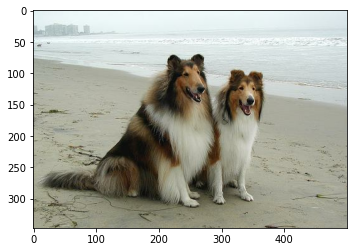

In [3]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [4]:
# 미리 학습해 놓은 모델 가중치 가져오기
import os
cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

In [5]:
# 데이터셋에 한 장씩 뽑기
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

In [6]:
def generate_cam(model, item):
    # generate cam image
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0]
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        cam_image += w * conv_outputs[:, :, i]
        
    cam_image /= np.max(cam_image)
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height))
    return cam_image

**만든 함수로 CAM 이미지를 생성**

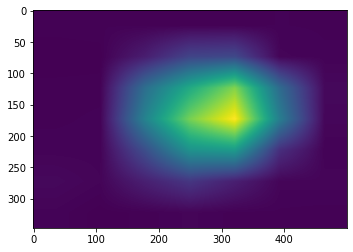

In [7]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

**원본 이미지와 CAM 이미지를 입력으로 받고 두 개의 이미지의 투명도를 조정, 하나의 이미지에서 원본과 CAM을 겹쳐 보여주기**

In [9]:
def visualize_cam_on_image(image, cam_image, alpha=0.6):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(image, alpha, cam_image, beta, 0.0)
    return merged_image

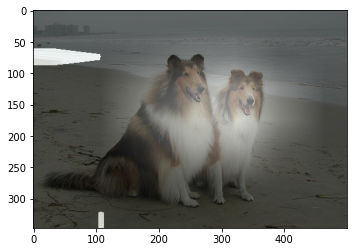

In [10]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

**Grad-CAM 구현하기**
1) Grad-CAM 직접 구현하기

In [11]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])    
    
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
        loss = pred[:, class_idx]
        output = conv_output[0]
        grad_val = tape.gradient(loss, conv_output)[0]
        
    weights = np.mean(grad_val, axis=(0,1))
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    
    return grad_cam_image

2) 만든 함수로 여러 레이어의 CAM 이미지를 뽑아서 직접 확인

- conv3, conv4, conv5에서 나온 cam 이미지들을 뽑았다.

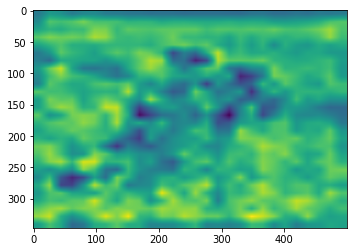

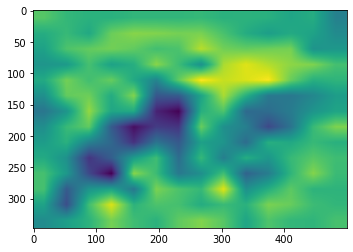

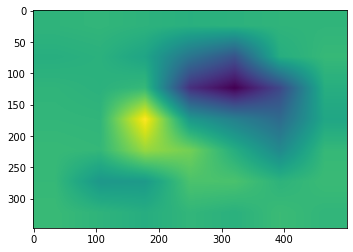

In [12]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

3) 위에서 만든 이미지 visualize_cam_on_image()함수로 이미지를 시각화

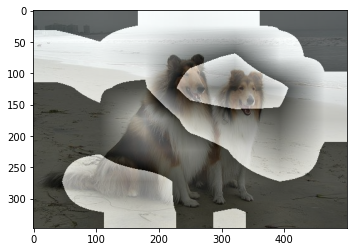

In [13]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

**바운딩 박스 구하기**
1) 제시된 코드를 참고해, 직접 Grad-CAM으로 얻은 CAM을 통해서 바운딩 박스를 얻기

In [14]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0 # 역치값 이하는 없애기
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours, _ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt) # 2차원 포인터들로 반환
    rect = cv2.boxPoints(rotated_rect) # 회전된 바운딩 박스를 다시 제자리로
    rect = np.int0(rect) # float에서 int로 바꿈
    return rect    

In [15]:
rect = get_bbox(cam_image)
rect

array([[111,  40],
       [453,  32],
       [460, 302],
       [118, 310]])

In [22]:
rect2 = get_bbox(grad_cam_image)
rect2

array([[437, 223],
       [499, 223],
       [499, 300],
       [437, 300]])

2) 바운딩박스를 시각화

- cam_model의 박스

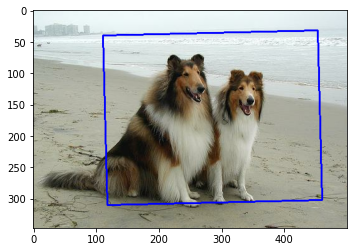

In [23]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0, 0, 255), 2)
plt.imshow(image)
plt.show()

- grad_cam_model의 박스

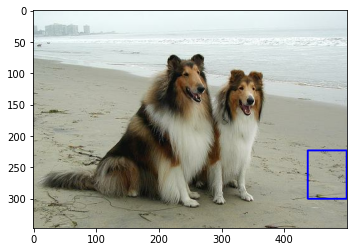

In [24]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect2], 0, (0, 0, 255), 2)
plt.imshow(image)
plt.show()

**IoU 구하기**
1) 정답 바운딩 박스(ground truth)와 예측값 바운딩 박스(prediction box) 두 가지를 이용해서 IoU를 계산하는 get_iou() 함수 만들기

In [25]:
# 예측값의 좌표를 반환하는 함수
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [26]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.09221902017291066, 0.222, 0.8933717579250721, 0.92]

In [35]:
pred_bbox2 = rect_to_minmax(rect2, item['image'])
pred_bbox2

[0.6426512968299711, 0.874, 0.8645533141210374, 0.998]

In [36]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min = max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou   

In [37]:
get_iou(pred_bbox,item['objects']['bbox'][0])

0.35141132309225515

In [38]:
get_iou(pred_bbox2,item['objects']['bbox'][0])

0.0

**회고**

cam_model은 IoU가 0.35, grad_cam_model은 IoU가 0이므로 cam_model이 더 성능이 좋다.